# Bandit QNN in Genomic dataset

 This algorithm is a QCB framework that allow clients to use greedy policy to interact with environment. It is implemented in genomic dataset, in whose scenario the client can get feedback, and use the feedback as part of the new training dataset, to allow them converge in an uncertain environment. 

## Load Genomic dataset

In [11]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

#test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
#print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the train set: {len(train_set)}")

d:\software\Anaconda\envs\qfcb\lib\site-packages\genomic_benchmarks\utils\datasets.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Nuber of samples in the train set: 75000


## Genomics Data

Now, let's take a closer look at what the genomic data looks like. The data consists of DNA sequences, each represented as a string with a length of 200 characters, and an associated label, which can be either 0 or 1. In this context, 0 typically represents human DNA, while 1 corresponds to worm DNA.

For our specific use case, we need to reduce the dimensionality of this data. One approach is to encode the DNA sequence characters as follows:
- 'A' as 1
- 'T' as 2
- 'C' as 3
- 'G' as 4
- 'N' as 5

Since we know that DNA sequences contain only these characters. However, working with 200 features for each sequence might be too complex. In the next step, we'll work on reducing the dimensionality of this data from 200 features down to a single digit, such as 5 or 4.
## Creating a Dictionary of DNA Sequence Representations

In the following code snippet, we create a dictionary named `word_combinations`. This dictionary is designed to hold numerical representations of DNA sequences. Our goal is to convert the DNA sequences into a more manageable format.

To achieve this, we define a variable called `word_size`, which specifies the length of each word we want to consider in the DNA sequence. In this particular case, `word_size` is set to 40, but you can adjust it based on your specific requirements.

The code iterates through each DNA sequence in the `data_set` and extracts overlapping subsequences of length `word_size`. These subsequences are represented as "words." For each unique word encountered in the DNA sequences, we assign a numerical representation.

The resulting `word_combinations` dictionary stores these numerical representations, allowing us to work with a simplified version of the DNA data.


In [12]:
from collections import defaultdict
import numpy as np

word_size = 40
word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1


In [13]:
print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)

First sample int the data_set variable: 
('TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTTTTCCATTATTTTCTCACATGTCAGGCTTCATTATATGTTTCACAGTCTTTATTATTATTTACCTTCCTCAGCTAGAATGTGAGTCCACAAGGATAGGTCTGAACTCTTTTACTCACAGCATTTCTGACCCCCAAATATGTGTCTTTTGTCCT', 0)

First 5 samples in the word_combinations dict.
TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCT 1
CAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTG 2
AGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGC 3
GCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCT 4
CCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTT 5


## Encoding DNA Sequences

In the following code segment, we encode the 200-character DNA sequences into smaller samples, each comprising 200 divided by the `word_size` segments. This encoding allows us to represent the DNA sequences in a numerical format by assigning a numerical value from the `word_combinations` dictionary to each segment.

The specific steps in the code include:
1. Stripping any leading or trailing whitespace from the DNA sequence.
2. Dividing the DNA sequence into `word_size`-letter word segments using a sliding window approach.
3. Converting these word segments into their corresponding numerical values as per the `word_combinations` dictionary.
4. Organizing the data into a structured format that includes the numerical sequence and its associated label.

The resulting `np_data_set` holds these encoded data points.

In [14]:
import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]

First 5 samples of encoded data:


[{'sequence': array([  1,  41,  81, 121, 161]), 'label': 0},
 {'sequence': array([201, 201, 201, 201, 201]), 'label': 0},
 {'sequence': array([241, 281, 321, 361, 401]), 'label': 0},
 {'sequence': array([441, 481, 521, 561, 601]), 'label': 0},
 {'sequence': array([641, 681, 721, 761, 801]), 'label': 0}]

## Shuffling Data for Balanced Distribution

In the code segment above, we observe the first 5 samples of the `np_data_set` variable. It's apparent that all of these initial samples have a label of 0. This observation is due to the common dataset structure, where the data is organized such that the first batch of samples belongs to one class (in this case, class 0), followed by another class (class 1), and so on.

However, in the subsequent steps of this code, we'll divide the data into portions for each of our clients, and it's crucial to ensure that each client receives a balanced mix of data from both classes (0 and 1). Therefore, we need to shuffle the `np_data_set` variable.

Shuffling the dataset randomizes the order of samples, guaranteeing that no single client will receive data only from one class. This is essential for a more representative and fair distribution of data among clients.

In [15]:
np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]

First 5 samples of encoded shuffled data:


[{'sequence': array([3342238, 3342278, 3342318, 3342358, 3342398]),
  'label': 0},
 {'sequence': array([13468495, 13468535, 13468575, 13468615, 13468655]),
  'label': 1},
 {'sequence': array([667968, 668008, 668048, 668088, 668128]), 'label': 0},
 {'sequence': array([12706987, 12707027, 12707067, 12707107, 12707147]),
  'label': 1},
 {'sequence': array([794067, 794107, 794147, 794187, 794227]), 'label': 0}]

## Scaling the Data with Min-Max Scaling

In the code provided, we apply Min-Max scaling to the dataset to normalize the numerical values. This process is valuable for ensuring that the features of the dataset are within a consistent range, typically between 0 and 1.

Here's how the code accomplishes this:
1. We collect the sequences from the `np_data_set` variable and stack them into an array.
2. We create a `MinMaxScaler` object, which will be used to perform the scaling.
3. The scaler is then applied to the sequences using `scaler.fit_transform()`.
4. The scaled sequences are replaced in each data point within the `np_data_set` variable.

As a result, the sequences' values are transformed to a standardized scale, making it easier to work with the data and ensuring that each feature has the same weight in subsequent analyses.

The output displays the first 5 samples of the scaled, encoded, and shuffled data, highlighting how the values are now in the [0, 1] range after the scaling process.

In [16]:
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]

First 5 samples of scaled encoded shuffled data:


[{'sequence': array([0.24222412, 0.24222412, 0.24222194, 0.24222194, 0.24222194]),
  'label': 0},
 {'sequence': array([0.97611094, 0.97611094, 0.97610217, 0.97610217, 0.97610217]),
  'label': 1},
 {'sequence': array([0.04841001, 0.04841001, 0.04840957, 0.04840957, 0.04840957]),
  'label': 0},
 {'sequence': array([0.92092168, 0.92092168, 0.9209134 , 0.9209134 , 0.9209134 ]),
  'label': 1},
 {'sequence': array([0.05754886, 0.05754886, 0.05754835, 0.05754835, 0.05754835]),
  'label': 0}]

## Splitting the Dataset and Preparing Test Data

In the previous section, we divided the `np_data_set` variable into two subsets, with 70,000 samples earmarked for training and 5,000 samples reserved for testing. This division is crucial for the development and evaluation of our Quantum Federated Learning model, ensuring that we have separate datasets for these purposes.

Following the split, we proceed to prepare the test data for further analysis and evaluation. We extract the sequences and labels from the testing dataset. This separation is essential as it allows us to analyze the data and labels separately, facilitating model evaluation and performance assessment.

At this point, the test data is organized into two variables:
- `test_sequences`: An array containing the sequences from the test data.
- `test_labels`: An array containing the corresponding labels from the test data.

These variables will be used in subsequent steps to evaluate the model's performance on the testing data.


In [17]:
features = [data_point["sequence"] for data_point in np_data_set]
labels = [data_point["label"] for data_point in np_data_set]
features = np.array(features)
labels = np.array(labels)
print(features[:5])
print(labels[:5])

[[0.24222412 0.24222412 0.24222194 0.24222194 0.24222194]
 [0.97611094 0.97611094 0.97610217 0.97610217 0.97610217]
 [0.04841001 0.04841001 0.04840957 0.04840957 0.04840957]
 [0.92092168 0.92092168 0.9209134  0.9209134  0.9209134 ]
 [0.05754886 0.05754886 0.05754835 0.05754835 0.05754835]]
[0 1 0 1 0]


## Training with QNN

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [18]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)
print(train_features[:8], test_features[:8], train_labels[:8], test_labels[:8])
train_set = []
test_set = []
for i in range(len(train_features)):
    train = {'sequence': train_features[i], 'label': train_labels[i]}
    train_set.append(train)
for i in range(len(test_features)):
    test = {'sequence': test_features[i], 'label': test_labels[i]}
    test_set.append(test)



[[0.22981569 0.22981569 0.22981362 0.22981362 0.22981362]
 [0.47378585 0.47378585 0.47378159 0.47378159 0.47378159]
 [0.30946778 0.30946778 0.309465   0.309465   0.309465  ]
 [0.14373178 0.14373178 0.14373048 0.14373048 0.14373048]
 [0.24246944 0.24246944 0.24246727 0.24246727 0.24246727]
 [0.87821991 0.87821991 0.87821202 0.87821202 0.87821202]
 [0.82145746 0.82145746 0.82145008 0.82145008 0.82145008]
 [0.37637589 0.37637589 0.37637251 0.37637251 0.37637251]] [[0.53774261 0.53774261 0.53773778 0.53773778 0.53773778]
 [0.40263629 0.40263629 0.40263267 0.40263267 0.40263267]
 [0.22177829 0.22177829 0.2217763  0.2217763  0.2217763 ]
 [0.12869777 0.12869777 0.1286961  0.1286961  0.1286961 ]
 [0.07260164 0.07260164 0.07260099 0.07260099 0.07260099]
 [0.79437478 0.79437478 0.79436764 0.79436764 0.79436764]
 [0.13415837 0.13415837 0.13415716 0.13415716 0.13415716]
 [0.6268415  0.6268415  0.62683587 0.62683587 0.62683587]] [0 0 0 0 0 1 1 0] [1 0 0 0 0 1 0 1]


Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

In [19]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

## Use QNN 
design a qnn circuit, which use 2 qubits, 4 inputs and 4 weights

input parameters: ['input[0]', 'input[1]', 'input[2]', 'input[3]', 'input[4]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]', 'weight[8]', 'weight[9]']


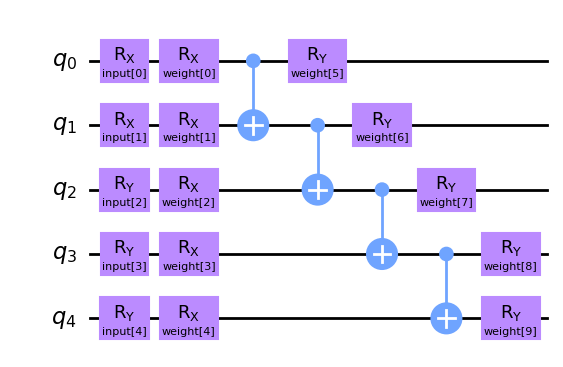

In [20]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

inputs = ParameterVector("input", 5)
weights = ParameterVector("weight", 10)
print(f"input parameters: {[str(item) for item in inputs.params]}")
print(f"weight parameters: {[str(item) for item in weights.params]}")

qc = QuantumCircuit(5)
qc.rx(inputs[0], 0)
qc.rx(inputs[1], 1)
qc.ry(inputs[2], 2)
qc.ry(inputs[3], 3)
qc.ry(inputs[4], 4)

qc.rx(weights[0], 0)
qc.rx(weights[1], 1)
qc.rx(weights[2], 2)
qc.rx(weights[3], 3)
qc.rx(weights[4], 4)

qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)

qc.ry(weights[5], 0)
qc.ry(weights[6], 1)
qc.ry(weights[7], 2)
qc.ry(weights[8], 3)
qc.ry(weights[9], 4)
qc.draw("mpl", style="clifford")

Use a callback function to draw a histogram

In [21]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Define interpret function to map 4 outputs into 3 categories. Instantiate samplerQNN and NeutralNetworkClassifier.

In [22]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendSampler       
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
import qiskit_aer.noise as noise


## Quantum Noise

In [23]:
backend = AerSimulator()

noise_model = NoiseModel.from_backend(backend)
print(noise_model)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

NoiseModel: Ideal


d:\software\Anaconda\envs\qfcb\lib\site-packages\qiskit_aer\noise\noise_model.py:377: UserWarning: Qiskit backend AerSimulator('aer_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


### depolarizing noise model

In [24]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

### Pauli noise model

In [ ]:
from qiskit.circuit.library.standard_gates import XGate, YGate
from qiskit.quantum_info.operators import Pauli
x = XGate()
y = YGate()
noise_ops = [(Pauli(x),0.1),(Pauli(y),0.9)]
# Pauli quantum errors
error = noise.pauli_error(noise_ops)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['rx', 'ry'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

backend = AerSimulator(noise_model=noise_model,
                   coupling_map=coupling_map,
                   basis_gates=basis_gates)

In [25]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder

parity = lambda x: "{:b}".format(x).count("1") % 2 
output_shape = 2  # 0, 1, 2 one-hot encoding


In [12]:
shots = 100
sampler = Sampler(options={"shots": shots})
optimizer = COBYLA(maxiter=40)
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=weights,
    interpret=parity,
    output_shape=output_shape,
    #sampler=sampler
    sampler = BackendSampler(backend=backend)
)

qnn = NeuralNetworkClassifier(
    sampler_qnn, 
    loss='squared_error', 
    one_hot=True, 
    optimizer=optimizer, 
    warm_start=True, 
    initial_point=None, 
    callback=callback_graph
    )


# clear objective value history
objective_func_vals = []


### Train QNN without bandit and FL

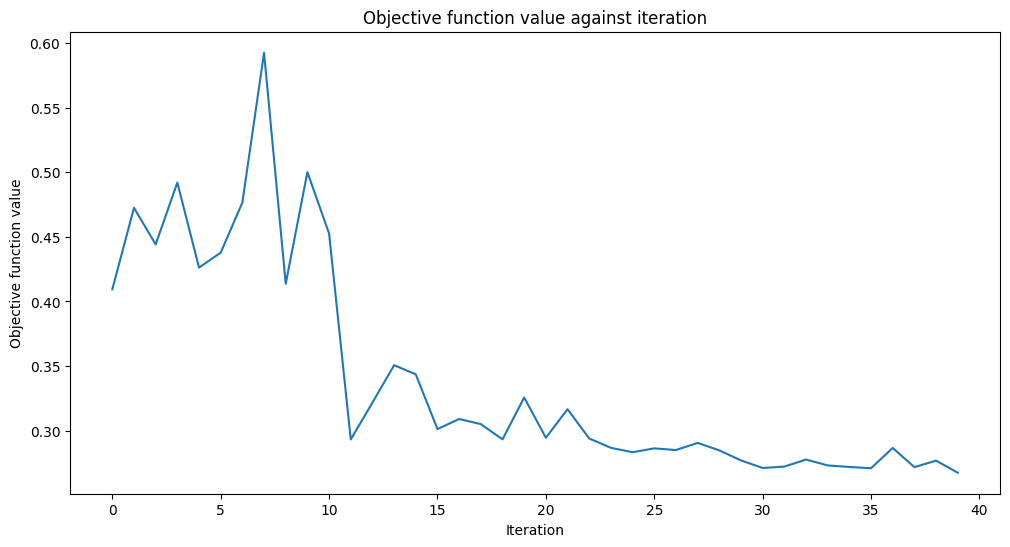

Training time: 3579 seconds
0.9986666666666667
Precision: 1.00
Recall: 1.00
Quantum QNN on the training dataset: 1.00
Quantum QNN on the test dataset:     1.00
[ 0.55975345 -0.21517516 -0.05249589  0.19551131  0.09017355  0.36659715
 -0.03958227  0.52885646  0.19975711  0.54983157]


In [13]:
from sklearn.metrics import precision_score, recall_score

start = time.time()
qnn.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

print(qnn.score(test_features, test_labels, sample_weight=None))

train_score_q4 = qnn.score(train_features, train_labels)
test_score_q4 = qnn.score(test_features, test_labels)
pred_labels = qnn.predict(test_features)
assert test_labels.ndim == 1, "test_labels should be a 1D array"
precision = precision_score(test_labels, pred_labels)
print(f'Precision: {precision:.2f}')
recall = recall_score(test_labels, pred_labels)
print(f'Recall: {recall:.2f}')

print(f"Quantum QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QNN on the test dataset:     {test_score_q4:.2f}")

print(qnn.weights)

In [ ]:
qnn.weights = [0.55975345, -0.21517516, -0.05249589,  0.19551131,  0.09017355,  0.36659715,
 -0.03958227,  0.52885646,  0.19975711,  0.54983157]

## Environment Model: generating bandit data
Unlike before, we add an exploration module to this model. In the process of deploying the model, when the user uses the model, the model does not necessarily give the predicted label, but there is a certain probability that the model will give the user other labels. Generate a feedback record of whether the user approved of the tag. This feedback record includes input features, predicted labels, selected labels, and exploration probabilities.

The model starts with initial weights and is already ready to make predictions. Based on the input, it will produce a predicted output. Store the results of this model. During the midway process, the model can be optimized. The bandit algorithm is used to dynamically optimize the QFL model and explore the needs of users. The needs of users themselves will also change.

In [26]:
import random
import collections
import tensorflow as tf

### Epsilon Greedy

In [7]:
def epsilon_greedy_bandit_data(data,model,epsilon):
    train_sequences = [data_point["sequence"] for data_point in data]
    train_labels = [data_point["label"] for data_point in data]
    # Convert the lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    arms_num = 2
    #模型预测值
    pred_action = model.predict(train_sequences)
    # get predicted vector in logits way
    logits = sampler_qnn.forward(train_sequences, model.weights)
    action_list = []
    reward_list = []
    prob_list = []
    arr = [0,1]
    print("Inference Started")
    for i in range(len(pred_action)):
        t =  random.random()
        if t < epsilon:
            remaining_action = [x for x in arr if x != pred_action[i]]
            action = random.choice(remaining_action)
            #print(action)
        else:
            action = pred_action[i]
            #print(action)
        action_list.append(action)

        if action == train_labels[i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)

        action_match_pred = (action_list[i]==pred_action[i])
        per_action_epsilon = epsilon / tf.cast(arms_num, dtype=tf.float32)
        prob = (1 - epsilon + per_action_epsilon) * action_match_pred + (
          1.0 - action_match_pred) * per_action_epsilon
        prob_list.append(prob)
    print("Inference Completed")
    
    action_logits = tf.gather(logits, action_list, axis=1, batch_dims=1).numpy()
    weight_scale = tf.math.minimum(
          1 - epsilon + per_action_epsilon, per_action_epsilon
      )
    new_y = collections.OrderedDict([
          ('label', pred_action),
          ('action', action_list),
          ('reward', reward_list),
          ('prob', prob_list),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
    bandits_data = collections.OrderedDict(x=train_sequences, y=new_y)
    
    return bandits_data

    
#bandits_data = epsilon_greedy_bandit_data(qnn,0.2)
#print(bandits_data)




### Falcon

In [27]:
def falcon_bandit_data(data,model,mu,gamma):
  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]
  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  pred_action = model.predict(train_sequences)
  pred_logits = sampler_qnn.forward(train_sequences, model.weights)
  #print("pred_logits:",pred_logits)
  batch_size = tf.shape(pred_logits)[0]
  num_arms = tf.shape(pred_logits)[1]
  greedy_action = tf.argmax(pred_logits, axis=1, output_type=tf.int32)
  #print("greedy_action:",greedy_action)
  greedy_logits = tf.gather(pred_logits, greedy_action, axis=1, batch_dims=1)
  #print("greedy_logits:",greedy_logits)
  nongreedy_res = tf.expand_dims(greedy_logits, axis=1) - pred_logits
  #print("nongreedy_res:",nongreedy_res)
  nongreedy_prob = 1.0 / (mu + gamma * nongreedy_res)
  #print("nongreedy_prob:",nongreedy_prob)
  greedy_indicator = tf.one_hot(
      greedy_action, depth=num_arms, on_value=True, off_value=False
  )
  #print("greedy_indicator",greedy_indicator)
  nongreedy_prob = tf.where(
      greedy_indicator, tf.zeros_like(pred_logits), nongreedy_prob
  )
  #print("nongreedy_prob",nongreedy_prob)
  # Normalize nongreedy_prob if the sum of probablility is larger than 1 so that
  # it is still a probability distribution to be sampled even if mu and gamma
  # are not properly set.
  nongreedy_prob = nongreedy_prob / tf.math.maximum(
      1.0, tf.math.reduce_sum(nongreedy_prob, axis=1, keepdims=True)
  )
  greedy_prob = 1.0 - tf.math.reduce_sum(nongreedy_prob, axis=1)
  greedy_idx = tf.stack([tf.range(batch_size), greedy_action], axis=1)
  prob = (
      tf.scatter_nd(greedy_idx, greedy_prob, shape=tf.shape(pred_logits))
      + nongreedy_prob
  )
  cumsum_prob = tf.math.cumsum(prob, axis=1)
  cumsum_prob = tf.cast(cumsum_prob, dtype=tf.float32)
  # We can use tf.random.uniform for independent noise on clients, see
  # https://www.tensorflow.org/federated/tutorials/random_noise_generation
  random_val = tf.random.uniform(
      shape=[batch_size], minval=0, maxval=1, dtype=tf.float32
  )
  less_idx = tf.math.less(tf.expand_dims(random_val, axis=1), cumsum_prob)
  # The `action_helper` is constructed so that if the `cumsum_prob` is larger
  # than or equal to `random_val`, the values are the action index; if
  # `cumsum_prob` is smaller, the values are a constant number of the largest
  # possible index of action. When taking the min of `action_helper`,
  # the action where random_val falls in the `cumsum_prob` backet is returned;
  # i.e., the action is sampled based on the falcon `prob`.
  action_helper = tf.where(
      less_idx,
      tf.broadcast_to(
          tf.range(num_arms, dtype=tf.int32), shape=[batch_size, num_arms]
      ),
      (num_arms - 1) * tf.ones(shape=(batch_size, num_arms), dtype=tf.int32),
  )

  # bandit data
  action = tf.math.reduce_min(action_helper, axis=1).numpy()
  print("action:", action)
  action_prob = tf.gather(prob, action, axis=1, batch_dims=1).numpy()
  action_logits = tf.gather(pred_logits, action, axis=1, batch_dims=1).numpy()
  reward_list = []
  for i in range(batch_size):
    if action[i] == train_labels[i]:
        reward = 2
    else:
        reward = -2
    reward_list.append(reward)
  #print("reward:",reward_list)
  weight_scale = 1.0 / (mu + gamma)
  new_y = collections.OrderedDict([
          ('label', pred_action),#predicted action
          ('action', action),#actual action
          ('reward', reward_list),#comparation between correct action(test_label) and actual action
          ('prob', action_prob),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
  return collections.OrderedDict(x=train_sequences, y=new_y)


#bandits_data = falcon_bandit_data(train_set,qnn,0.5,10)
#print("----------------------------------------------------------------------")
#print(bandits_data['y']['logits'])


### Softmax Sampling

In [17]:
def softmax_sampling_bandit_data(data,model,temperature):
    train_sequences = [data_point["sequence"] for data_point in data]
    train_labels = [data_point["label"] for data_point in data]
    # Convert the lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    pred_action = model.predict(train_sequences)
    pred_logits = sampler_qnn.forward(train_sequences, model.weights)
    batch_size = tf.shape(pred_logits)[0]
    num_arms = tf.shape(pred_logits)[1]
    prob = tf.keras.activations.softmax(pred_logits/temperature, axis=-1)
    cumsum_prob = tf.math.cumsum(prob, axis=1)
    cumsum_prob = tf.cast(cumsum_prob, dtype=tf.float32)
    # We can use tf.random.uniform for independent noise on clients, see
    # https://www.tensorflow.org/federated/tutorials/random_noise_generation
    random_val = tf.random.uniform(
        shape=[batch_size], minval=0, maxval=1, dtype=tf.float32
    )
    less_idx = tf.math.less(tf.expand_dims(random_val, axis=1), cumsum_prob)
    # The `action_helper` is constructed so that if the `cumsum_prob` is larger
    # than or equal to `random_val`, the values are the action index; if
    # `cumsum_prob` is smaller, the values are a constant number of the largest
    # possible index of action. When taking the min of `action_helper`,
    # the action where random_val falls in the `cumsum_prob` backet is returned;
    # i.e., the action is sampled based on the softmax `prob`.
    action_helper = tf.where(
        less_idx,
        tf.broadcast_to(
            tf.range(num_arms, dtype=tf.int32), shape=[batch_size, num_arms]
        ),
        (num_arms - 1) * tf.ones(shape=(batch_size, num_arms), dtype=tf.int32),
    )
    action = tf.math.reduce_min(action_helper, axis=1).numpy()
    print("action:", action)
    action_prob = tf.gather(prob, action, axis=1, batch_dims=1).numpy()
    action_logits = tf.gather(pred_logits, action, axis=1, batch_dims=1).numpy()
    reward_list = []
    for i in range(batch_size):
        if action[i] == train_labels[i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)
    #print("reward:",reward_list)
    weight_scale = 1.0 
    new_y = collections.OrderedDict([
          ('label', pred_action),#predicted action
          ('action', action),#actual action
          ('reward', reward_list),#comparation between correct action(test_label) and actual action
          ('prob', action_prob),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
    return collections.OrderedDict(x=train_sequences, y=new_y)


#bandits_data = softmax_sampling_bandit_data(qnn,0.05)
#print("----------------------------------------------------------------------")
#print(bandits_data)


## Implementing the Bandit in QNN
Use bandit data to train the QNN. Mainly change the loss function.

### Loss function with weights

In [28]:

from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss,L2Loss,Loss
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
class L1Loss_w():
    r"""
    This class computes the L1 loss (i.e. absolute error) for each sample as:

    .. math::

        \text{L1Loss}(predict, target) = \sum_{i=0}^{N_{\text{elements}}} \left| predict_i -
        target_i \right|.
    """
    def __call__(self, predict: np.ndarray, target: np.ndarray,weights: np.ndarray = None) -> np.ndarray:
        """
        This method calls the ``evaluate`` method. This is a convenient method to compute loss.
        """
        return self.evaluate(predict, target)

    def evaluate(self, predict: np.ndarray, target: np.ndarray,weights: np.ndarray = None) -> np.ndarray:
        self._validate_shapes(predict, target)
        if weights is None:
            if len(predict.shape) <= 1:
                return np.abs(predict - target)
            else:
                return np.linalg.norm(predict - target, ord=1, axis=tuple(range(1, len(predict.shape))))
        else:
            if len(predict.shape) <= 1:
                return np.abs(predict - target)*weights
            else:
                return np.linalg.norm(predict - target, ord=1, axis=tuple(range(1, len(predict.shape))))*weights

    def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
        self._validate_shapes(predict, target)

        return np.sign(predict - target)
    @staticmethod
    def _validate_shapes(predict: np.ndarray, target: np.ndarray) -> None:
        """
        Validates that shapes of both parameters are identical.

        Args:
            predict: an array of predicted values using the model
            target: an array of the true values

        Raises:
            QiskitMachineLearningError: shapes of predict and target do not match.
        """

        if predict.shape != target.shape:
            raise QiskitMachineLearningError(
                f"Shapes don't match, predict: {predict.shape}, target: {target.shape}!"
            )

### Bandit Process

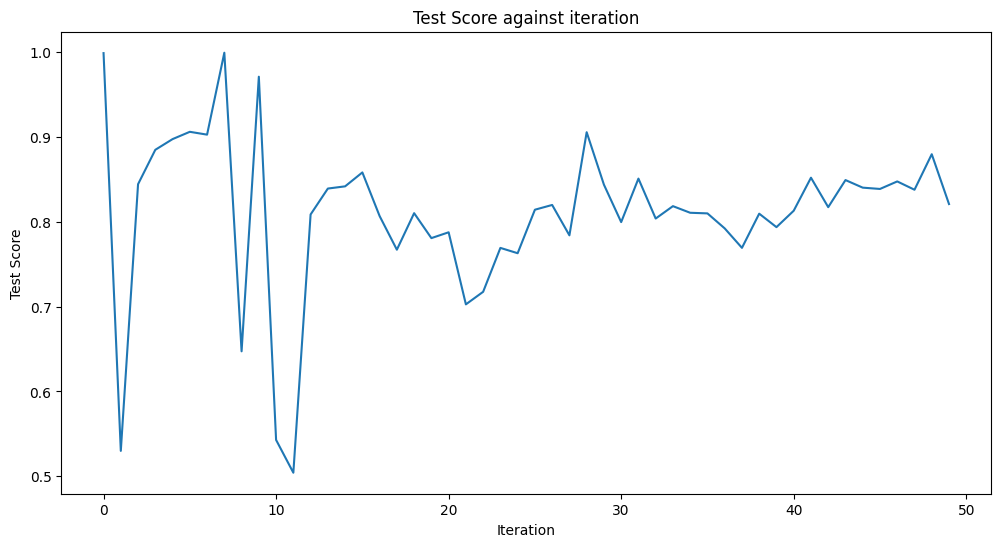

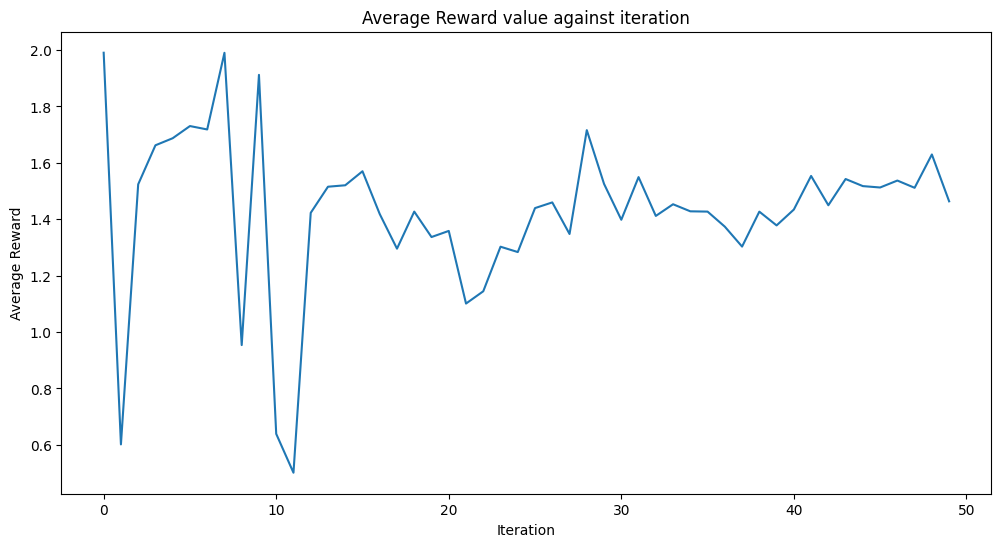

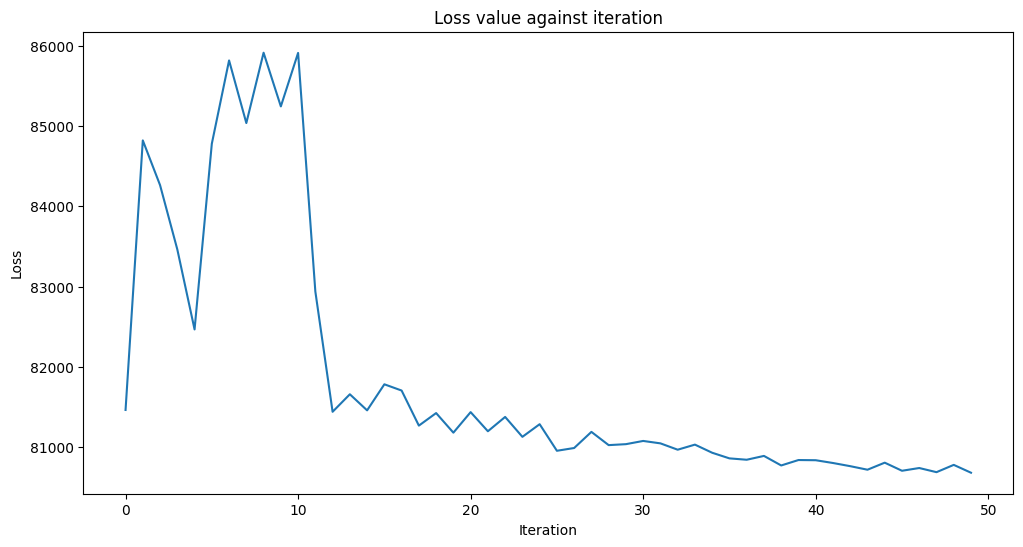

[ 0.28654519 -0.75568257 -0.10398003  0.17118136  0.01613909 -0.00674021
  0.0514999   0.3978136   0.0026363   0.44106978]
Precision: 1.00
Recall: 0.64


In [41]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
import numpy as np
scoreList = []
rewardList = []
lossList = []
def callback_bandit(score,reward,loss):
    clear_output(wait=True)
    scoreList.append(score)
    plt.title("Test Score against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Test Score")
    plt.plot(range(len(scoreList)), scoreList)
    plt.show()

    rewardList.append(reward)
    plt.title("Average Reward value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.plot(range(len(rewardList)), rewardList)
    plt.show()

    lossList.append(loss)
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(lossList)), lossList)
    plt.show()
    


def banditLoss(weights):
    qnn.fit_result.x = weights
    # epsilon greedy
    #bandits_data = epsilon_greedy_bandit_data(train_set,qnn,0.35)
    # falcon
    bandits_data = falcon_bandit_data(train_set,qnn,60,100)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(train_set,qnn,0.05)
    
    logits = np.array(bandits_data['y']['logits'])
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    prob = np.array(bandits_data['y']['prob'])
    weight_scale = np.array(bandits_data['y']['weight_scale'])
    sample_weights =  weight_scale / prob
    #label = np.array(bandits_data['y']['label'])

    #cross entropy loss
    #loss_function = CrossEntropyLoss()
    #loss = loss_function(logits, reward)
    #loss_item = float(np.squeeze(loss))
    #print("Loss:", loss_item)

    #squared error
    #loss_function = L2Loss()
    #loss = loss_function(logits, reward)
    #loss_item = sum(loss)
    #print("Loss:", loss_item)

    #squared error
    loss_function = L1Loss_w()
    loss = loss_function(logits,reward,sample_weights)
    loss_item = sum(loss)
    print("Loss_5:", loss_item)
    print("logits:",logits)
    print("reward_avg:",sum(reward)/len(reward))
    
    print("Score:", qnn.score(test_features, test_labels))
    print("sum_reward:",sum_reward)
    #print(qnn.fit_result.x)
    #print(qnn.weights)
    score = qnn.score(test_features, test_labels)
    precision = precision_score(test_labels, pred_labels)
    print(f'Precision: {precision:.2f}')
    recall = recall_score(test_labels, pred_labels)
    print(f'Recall: {recall:.2f}')
    avg_reward = sum_reward/len(reward)
    #callback_bandit(score)
    callback_bandit(score,avg_reward,loss_item)
    return loss_item

#optimizer = GradientDescent(maxiter=100, learning_rate=0.01)
optimizer = COBYLA(maxiter=50)
fit_result = optimizer.minimize(fun=banditLoss, x0=qnn.weights)
#qnn.initial_point = weights['x']
#print(qnn.fit_result.x)
#print("result:", k)
qnn.fit_result.x = fit_result.x
print(qnn.weights)
pred_labels = qnn.predict(test_features)
assert test_labels.ndim == 1, "test_labels should be a 1D array"
precision = precision_score(test_labels, pred_labels)
print(f'Precision: {precision:.2f}')
recall = recall_score(test_labels, pred_labels)
print(f'Recall: {recall:.2f}')




In [42]:
import statistics
#qnn.fit_result.x = [0.55975345, -0.21517516, -0.05249589, 0.19551131, 0.09017355, 0.36659715, -0.03958227, 0.52885646, 0.19975711, 0.54983157]
pred_labels = qnn.predict(test_features)
precision = precision_score(test_labels, pred_labels)
print(f'Precision: {precision}')
recall = recall_score(test_labels, pred_labels)
print(f'Recall: {recall}')
values = [precision,recall]
h_mean = statistics.harmonic_mean(values)
print(f'Harmonic Mean(F1){i}: {h_mean}')
bandits_data = falcon_bandit_data(test_set,qnn,60,100)
reward = np.array(bandits_data['y']['reward'])
sum_reward=float(sum(reward))
avg_reward=sum_reward/len(reward)
#print(np.array(bandits_data['y']))
print(f'Average Reward: {avg_reward}')

Precision: 1.0
Recall: 0.638758231420508
Harmonic Mean(F1)14999: 0.7795637198622273
action: [0 0 0 ... 0 0 0]
Average Reward: 1.4614


In [21]:
print(qnn.score(test_features, test_labels, sample_weight=None))

train_score_q4 = qnn.score(train_features, train_labels)
test_score_q4 = qnn.score(test_features, test_labels)

print(f"Quantum QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QNN on the test dataset:     {test_score_q4:.2f}")

print(qnn.weights)

0.8208
Quantum QNN on the training dataset: 0.82
Quantum QNN on the test dataset:     0.82
[ 0.28654519 -0.75568257 -0.10398003  0.17118136  0.01613909 -0.00674021
  0.0514999   0.3978136   0.0026363   0.44106978]
